# Import Packages

In [1]:
# Version 2.0 : uses waveforms as a function of time ... 
import sys
import os

PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
sys.path.append(PATH_with_functions)

import glob
import xarray as xr
import numpy as np
import pandas as pd

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import scipy.interpolate as spi
import scipy.integrate as spint
from scipy.ndimage import gaussian_filter, correlate
from scipy.signal import hilbert,hilbert2,fftconvolve,deconvolve

from functions_cfosat_env import *
from surface_simulation_functions import *
from altimetry_waveforms_functions import *
from matplotlib.dates import DateFormatter
# --- plotting and interactive stuff ----------------------
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator, FixedLocator

#from Envelope_convolution_functions import *

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

cmap0 = 'viridis'

Chelton footprint diameter in km: 6.311156055213763
Maximum range used for retracking: 127
size of waveforms array: 1 1 127
Estimated noise level: 0.0010088133646248276 160.0
Retracking waveforms 0  out of  1  ------------ 
retracker gives: 9.992182010935242 -0.0020655080381570714 0.9997245215639481 nan nan 117.00099306162313


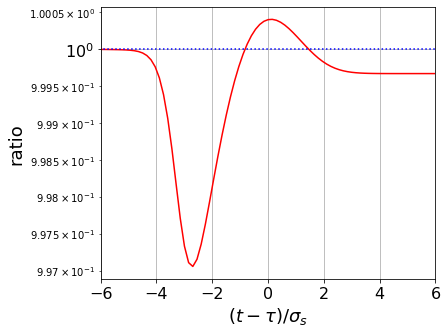

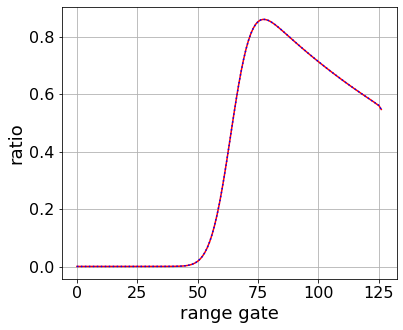

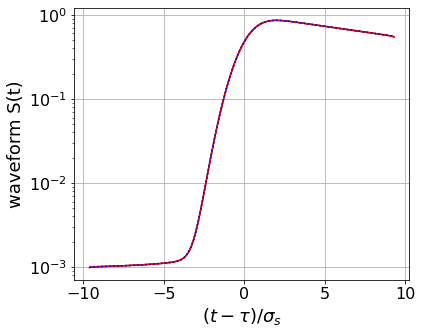

In [2]:
clight = 299792458
Rearth = 6370*1e3

# --- satellite parameters ----------------------------
v_sat = 7*1e3 # satellite velocity in m/s
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.

ialti = 0  # choice is SWIM on CFOSAT 

theta3dB=theta3dBs[ialti]
alti_sat = Altis[ialti]
bandwidth = BW[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
bandx     = BX[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
nameSat = namesAltis[ialti]
tau=1E9/bandwidth           # time interval in nanoseconds
stonano=1000000000

dr = clight * 1/(2*bandwidth)


Hs=10.0
sigs=0.25*Hs*2/clight*stonano
DiamChelton = calc_footprint_diam(Hs,Rorbit = alti_sat, pulse_width=1/bandwidth)
radi0=DiamChelton # size of diameter of footprint in pixel
print('Chelton footprint diameter in km:',DiamChelton*0.001)
nominal_tracking_gate=64
range_offset = nominal_tracking_gate*dr  # number of meters above nadir sea level included in waveform
nr=128

ranges = np.arange(0,(nr-1)*dr,dr)    # remember to increase 35 to higher values if needed
rlim = np.sqrt((radi0/2)**2+(alti_sat)**2)-alti_sat+range_offset
max_range_fit=127 #np.argmax(ranges[ranges<=rlim])

min_range_fit=0
print('Maximum range used for retracking:',max_range_fit)
wf_model='wf_erf4D'
wf_mod2='wf_erf2D'
tax=1E9/bandx

rtot=(2./clight)*stonano  #Converts range to time
times=ranges*rtot
nr2=int(nr/2)
t0=tau*(nr2-1)
PTR=(np.sinc(np.pi*(times-t0)/tax))**2

s=sum(PTR)
PTR=PTR.T/s
noise=1E-3
PTM='True'
#PTR=[1]
timeshift=tau*nominal_tracking_gate
    
wf_fit2=wf_eval(ranges,np.array((0,Hs,1.,0.0,0.)),clight,'wf_bro4D',PTR_model=PTM,PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

watable=np.zeros([1,1,127])
watable[0,0,:]=wf_fit2

#Hst,zet,Put,dart,R0rt,dit=retrack_waveforms(watable,ranges,max_range_fit,clight,tau=tau,\
#              min_method='pyramid3',PTR_model=PTM,PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
#             # min_method='Nelder-Mead',PTR_model=PTM,PTR=PTR, wf_model='wf_brown',costfun='LS',mispointing=[0.],\
#              theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)
#print('retracker gives:',Hst[0,0],zet[0,0],Put[0,0],dart[0,0],R0rt[0,0],dit[0,0])

Hst,zet,Put,dart,R0rt,dit=retrack_waveforms(watable,ranges,max_range_fit,clight,tau=tau,\
              min_method='Nelder-Mead',PTR_model=PTM,PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
              theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)

print('retracker gives:',Hst[0,0],zet[0,0],Put[0,0],dart[0,0],R0rt[0,0],dit[0,0])


wf_test=wf_eval(ranges,np.array((zet[0,0],Hst[0,0],Put[0,0])),clight,'wf_brown',PTR_model=PTM,PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)


wf_test2=wf_eval(ranges,np.array((0.,Hs,1.)),clight,'wf_brown',PTR_model=PTM,PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

Gamma =(np.sin(theta3dB))**2/(np.log(2)*2)
Zeta=0
mispointing=0
c_xi=0
clightn=clight/stonano
Ri=6378.1363*(10**3)
weights=ranges*0+1
costfun='LS'
b_xi = np.cos (2*mispointing) - ((np.sin(2*mispointing))**2)/Gamma
c_xi=b_xi* ( (4/Gamma)*(clightn/alti_sat) * 1/(1+alti_sat/Ri))
#di2=wf_brown(np.array((timeshift,10.*rtot,1.,0.,0.)),(wf_test2,Gamma,Zeta,times,c_xi,weights,noise,tau,costfun,PTR)) 
#di4=wf_brown(np.array((timeshift,10.*rtot,1.,0.,0.)),(wf_test,Gamma,Zeta,times,c_xi,weights,noise,tau,costfun,PTR)) 

#dia= (    ((wf_test[min_range_fit:max_range_fit] - wf_fit2[min_range_fit:max_range_fit]) **2)).sum()
#dic= (    ((wf_test2[min_range_fit:max_range_fit] - wf_fit2[min_range_fit:max_range_fit]) **2)).sum()

#print('di:',di2,di4,dia,dic)

fig,ax=plt.subplots(figsize=(6,5))
timep=(times-nominal_tracking_gate*tau)/sigs
line2=ax.plot(timep,wf_test/wf_fit2,color='r',label='fitted')
line3=ax.plot(timep,wf_test2/wf_fit2,color='b',linestyle='dotted',label='fitted')
ax.set_xlabel(r'$(t-\tau)/\sigma_s$', fontsize=18)
ax.set_ylabel('ratio', fontsize=18)
#leg = ax.legend(loc='lower right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlim((-6,6))
ax.set_yscale('log')

fig,ax=plt.subplots(figsize=(6,5))
line2=ax.plot(wf_test,color='r',label='fitted')
line3=ax.plot(wf_fit2,color='b',linestyle='dotted',label='fitted')
ax.set_xlabel('range gate', fontsize=18)
ax.set_ylabel('ratio', fontsize=18)
#leg = ax.legend(loc='lower right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)


fig,ax=plt.subplots(figsize=(6,5))
timep=(times-nominal_tracking_gate*tau)/sigs
line1=ax.plot(timep,wf_fit2,color='k',label='a= 0.1,b=x')
line2=ax.plot(timep,wf_test,color='r',label='fitted')
line3=ax.plot(timep,wf_test2,color='b',linestyle='dotted',label='fitted')
ax.set_xlabel(r'$(t-\tau)/\sigma_s$', fontsize=18)
ax.set_ylabel('waveform S(t)', fontsize=18)
#leg = ax.legend(loc='lower right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
#ax.set_xlim((-6,6))
ax.set_yscale('log')




## Loops on b to compute J

In [3]:


nb=81
barray=np.arange(start=0, stop=2.01, step=0.025)
waveforms=np.zeros([1,nb,nr-1])
waveforms0=np.zeros([1,nb,nr-1])
waveforms2=np.zeros([1,nb,nr-1])
a=0.1

m1=45

for ib in range(nb):
    b=barray[ib]
    wf_fit=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,wf_model,PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)
    wf_fit0=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,wf_model,PTR_model='True',PTR=([1.]),noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)
    wf_fit2=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,'wf_bro4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)
    waveforms[0,ib,:]=wf_fit[:]
    waveforms0[0,ib,:]=wf_fit0[:]
    waveforms2[0,ib,:]=wf_fit2[:]
    
    
Hs_1,ze_1,Pu,dar,R0r,di_1=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model=wf_mod2,costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1)

Hs_2,ze_2,Pu2,dar2,R0r2,di_2=retrack_waveforms(waveforms0,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=([1.]), wf_model=wf_mod2,costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1)

Hs_3,ze_3,Pu,dar,R0r,di_3=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model=wf_mod2,costfun='ML',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1)

Hs_4,ze_4,Pu,dar,R0r,di_1=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1)

Hs_5,ze_5,Pu,dar5,R0r5,di_5=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1)




size of waveforms array: 1 81 127
Estimated noise level: 0.0010094477120000708 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 81 127
Estimated noise level: 0.0010000000000000057 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 81 127
Estimated noise level: 0.0010094477120000708 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 81 127
Estimated noise level: 0.001008824707834939 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 81 127
Estimated noise level: 0.001008824707834939 160.0
Retracking waveforms 0  out of  1  ------------ 


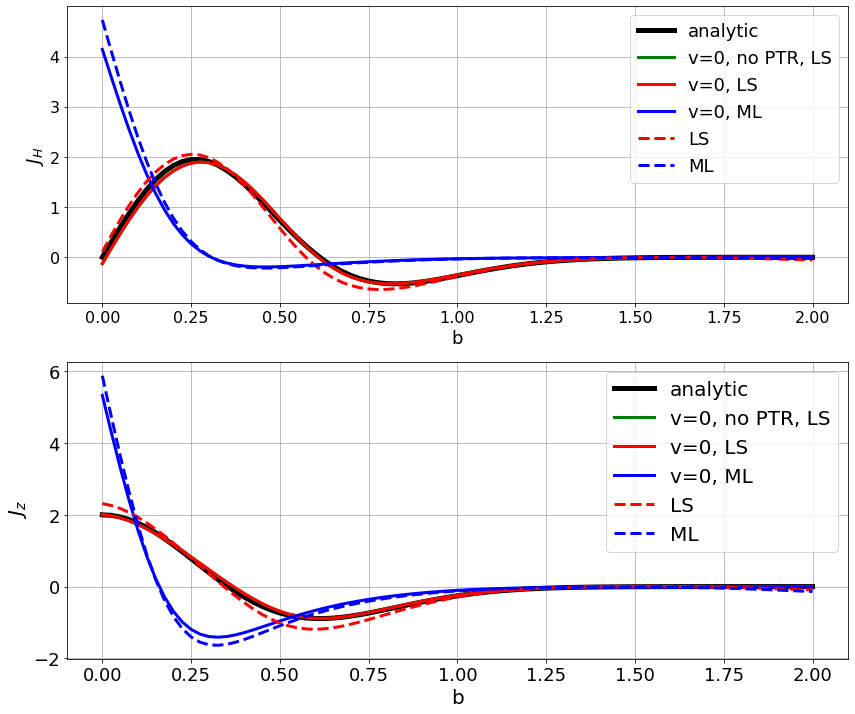

In [4]:
fig,axs=plt.subplots(2,1,figsize=(14,12))
ax=axs[0]
w1=5
w2=3
line1=ax.plot(barray,2*barray*(6- 16*barray**2)*np.exp(-4*barray**2),color='k',lw=w1,label='analytic')
line1=ax.plot(barray,2*(Hs_2.T-Hs)/(a*Hs),color='g',lw=w2,label='v=0, no PTR, LS')
line1=ax.plot(barray,2*(Hs_1.T-Hs)/(a*Hs),color='r',lw=w2,label='v=0, LS')
line1=ax.plot(barray,2*(Hs_3.T-Hs)/(a*Hs),color='b',lw=w2,label='v=0, ML')
line1=ax.plot(barray,2*(Hs_4.T-Hs)/(a*Hs),color='r',lw=w2,linestyle='dashed',label='LS')
line1=ax.plot(barray,2*(Hs_5.T-Hs)/(a*Hs),color='b',lw=w2,linestyle='dashed',label='ML')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='erf2D')
ax.set_xlabel('b', fontsize=18)
ax.set_ylabel(r'$J_H$ ', fontsize=18)
leg = ax.legend(loc='upper right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax=axs[1]
line1=ax.plot(barray,(2- 16*barray**2)*np.exp(-4*barray**2),lw=w1,color='k',label='analytic')
line1=ax.plot(barray,16*ze_2.T/(a*Hs),color='g',lw=w2,label='v=0, no PTR, LS')
line1=ax.plot(barray,16*ze_1.T/(a*Hs),color='r',lw=w2,label='v=0, LS')
line1=ax.plot(barray,16*ze_3.T/(a*Hs),color='b',lw=w2,label='v=0, ML')
line1=ax.plot(barray,16*ze_4.T/(a*Hs),color='r',lw=w2,linestyle='dashed',label='LS')
line1=ax.plot(barray,16*ze_5.T/(a*Hs),color='b',lw=w2,linestyle='dashed',label='ML')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='erf2D')
ax.set_xlabel('b', fontsize=20)
ax.set_ylabel(r' $J_z$', fontsize=20)
leg = ax.legend(loc='upper right', fontsize=20)
ax.tick_params(axis='both', labelsize=18)
fig.savefig('Fig4_Js_for_a_0p03_start45_lownoise.pdf')